# Turnbull

In [3]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import truncnorm

In [4]:
%run ../source/models/iceberg/iceberg.py
%run ../source/models/metocean/metocean.py
%run ../source/models/drift/turnbull.py
%run ../source/plotting/plot.py

# Iceberg

In [5]:
chosen_track_ind = 16
iip_berg_df = get_berg_df(2015, chosen_track_ind)
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,10483,2015,23460,6/25/2015,1111,47.52,-49.42,R/V,LG,GEN,GTJZ,2015-06-25 11:11:00
1,10484,2015,23460,6/25/2015,1859,47.53,-49.49,R/V,LG,GEN,GPGR,2015-06-25 18:59:00
2,10485,2015,23460,6/26/2015,1046,47.46,-49.53,R/V,GEN,GEN,GTJZ,2015-06-26 10:46:00
3,10486,2015,23460,6/27/2015,1036,47.44,-49.51,R/V,LG,GEN,GPGR,2015-06-27 10:36:00
4,10487,2015,23460,6/27/2015,1331,47.42,-49.53,RAD,GEN,GEN,2005,2015-06-27 13:31:00


In [6]:
iip_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'].loc[0],
                    iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                    [0], [0],
                    iip_berg_df['SIGHTING_LATITUDE'].loc[:].tolist(),
                    iip_berg_df['SIGHTING_LONGITUDE'].loc[:].tolist(),
                    iip_berg_df['SIZE'].loc[0],
                    iip_berg_df['SHAPE'].loc[0])

# Metocean

In [7]:
ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [8]:
ocean_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150625.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150626.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150627.nc']

In [9]:
atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                     min(iip_berg.lats), max(iip_berg.lats),
                     iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [10]:
atm_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150625.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150626.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150627.nc']

# Driver

In [11]:
vary_wind = True
vary_current = True

# Run number
run_num = 0
num_runs = 50
mod_berg_list = []


# Buffer number for bounding spatial box
buf = 0.5


for run_num in range(num_runs):

    # Create model iceberg
    mod_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'][0],
                        [iip_berg_df['TIMESTAMP'].dt.to_pydatetime()[0]],
                        [0], [0],
                        [iip_berg_df['SIGHTING_LATITUDE'][0]],
                        [iip_berg_df['SIGHTING_LONGITUDE'][0]],
                        iip_berg_df['SIZE'][0], iip_berg_df['SHAPE'].loc[0])

    mod_berg.length = [mod_berg.length]
    mod_berg.width = [mod_berg.width]
    mod_berg.height = [mod_berg.height]


    # Timesteps
    t0 = iip_berg.datetimes[0]
    tf = iip_berg.datetimes[-1]
    t_delta = tf - t0
    t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
    t_step_hours = 0.1
    t_step = timedelta(hours = t_step_hours)
    dt = t_step_hours*3600  # timestep in seconds
    t_all = []
    for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
        new_date = t0 + timedelta(hours=i)
        t_all.append(new_date)

    # Input field offsets
    # Note: average iceberg speed around NL is 0.2 m/s
    # Note: reasonable mean u,v velocities of current are: 0.11, -0.13 m/s 
    vwu_offset = truncnorm.rvs(-1,1, loc=ocean_data.mean_u, scale=ocean_data.std_u) 
    vwv_offset = truncnorm.rvs(-1,1, loc=ocean_data.mean_v, scale=ocean_data.std_v) 
    vw_offset = np.sqrt(vwu_offset**2 + vwv_offset**2)
    vw_dir_offset = truncnorm.rvs(-np.pi, np.pi, loc=ocean_data.mean_dir, scale=0.5)
    vwu_offset = vw_offset*np.cos(vw_dir_offset)
    vwv_offset = vw_offset*np.sin(vw_dir_offset)
    
    vau_offset = truncnorm.rvs(-20,20, loc=atm_data.mean_u, scale=atm_data.std_u) 
    vav_offset = truncnorm.rvs(-20,20, loc=atm_data.mean_v, scale=atm_data.std_v) 
    va_offset = np.sqrt(vau_offset**2 + vav_offset**2)
    va_dir_offset = truncnorm.rvs(-np.pi, np.pi, loc=atm_data.mean_dir, scale=0.5)
    vau_offset = va_offset*np.cos(va_dir_offset)
    vav_offset = va_offset*np.sin(va_dir_offset)
    
    # Iceberg Initials
    x0, y0 = mod_berg.lons[0], mod_berg.lats[0]
    l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
    vx0 = vwu_offset
    vy0 = vwv_offset
    
    l, w, h = l0, w0, h0
    x, y = x0, y0
    vx, vy = vx0, vy0
    
        
    print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))

    for t in t_all:


        t_ocean = nc.date2num(t, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
        t_atm = nc.date2num(t, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')
        
        vau = atm_data.iUA([t_atm, y, x])[0]
        vav = atm_data.iVA([t_atm, y, x])[0]
        vwu = ocean_data.iUW([t_ocean, y, x])[0]
        vwv = ocean_data.iVW([t_ocean, y, x])[0]
        #print('vwu, vwv = {}, {}'.format(np.round(vwu,2), np.round(vwv,2)))
        
        if vary_current:
            vwu += vwu_offset
            vwv += vwv_offset
        
        if vary_wind:
            vau += vau_offset
            vav += vav_offset
        
        #print('Timestep: {}'.format(t))

        vx, vy, x, y = turnbull_drift(mod_berg, vau, vav, vwu, vwv, dt) 


        if x > max(iip_berg.lons)+buf or x < min(iip_berg.lons)-buf or y > max(iip_berg.lats)+buf or y <= min(iip_berg.lats)-buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break


        else:
            mod_berg.xvels.append(vx)
            mod_berg.yvels.append(vy)
            mod_berg.lons.append(x)
            mod_berg.lats.append(y)
            mod_berg.datetimes.append(t)

    #mod_berg.datetimes.pop(0)
    print("Final time: {}".format(t)) 

    mod_berg_list.append(mod_berg)

Run number: 0, h = 391.35937101680173, l = 191.95978942182688, w = 148.17546632204062
Final time: 2015-06-27 13:35:00
Run number: 1, h = 431.1617842571666, l = 143.01289709334532, w = 199.09195794245983
Final time: 2015-06-27 13:35:00
Run number: 2, h = 285.91104042227545, l = 166.32744031935715, w = 123.01147298675653
Final time: 2015-06-27 13:35:00
Run number: 3, h = 283.72678677794386, l = 192.4923343103012, w = 130.45372824885337
Final time: 2015-06-27 13:35:00
Run number: 4, h = 311.0850307297526, l = 182.97426457401542, w = 170.51492772747605
out-of-bounds
Final time: 2015-06-26 14:59:00
Run number: 5, h = 403.3916580180821, l = 194.8850014608607, w = 129.3454212638679
Final time: 2015-06-27 13:35:00
Run number: 6, h = 408.38241291737074, l = 184.94929375306214, w = 167.52225144964456
Final time: 2015-06-27 13:35:00
Run number: 7, h = 349.09921621411206, l = 128.5025204098589, w = 173.00984889423162
Final time: 2015-06-27 13:35:00
Run number: 8, h = 327.35296652286206, l = 195.45

# Plotting

In [12]:
vx0

0.12458979783215844

In [13]:
vy0

-0.13182029415769306

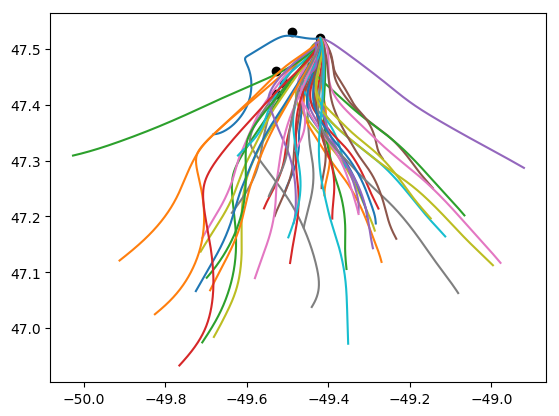

In [14]:
for berg in mod_berg_list:
    plt.plot(berg.lons, berg.lats)
plt.scatter(iip_berg.lons, iip_berg.lats, color='black')
plt.savefig('plots/spaghetti_ind{}.png'.format(chosen_track_ind))

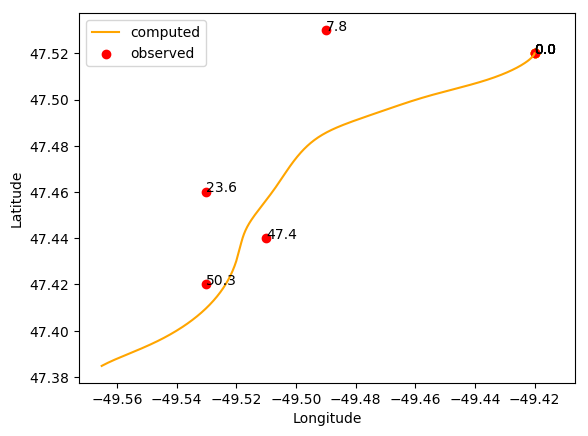

In [439]:
plot = plot_turnbull(iip_berg, mod_berg_list[0])

# Animations

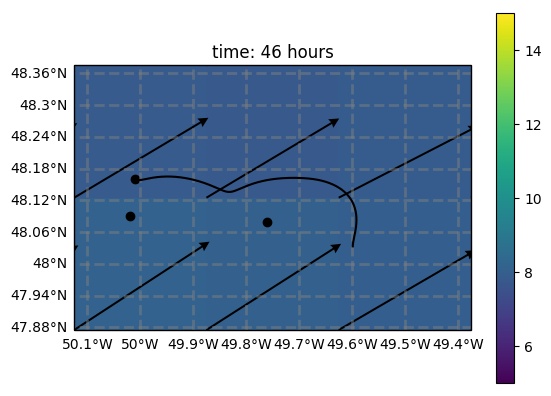

In [27]:
animate_winds(atm_data, iip_berg, mod_berg)

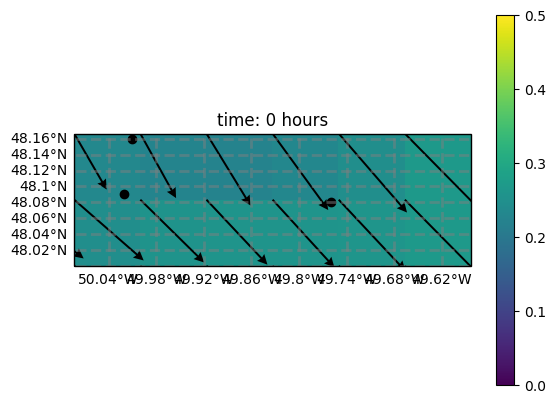

In [28]:
animate_currents(ocean_data, iip_berg, mod_berg)